In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import DataLoader
from utils import MultipleRegressionWithSoftmax, EmbeddingsDataset2

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr

In [2]:
n_classes = 2
modality = 'music' # 'music', 'speech', or 'video'
which = 'openl3' # 'mfcc', 'msd' or 'openl3' for music, 'slow_fast' for video, 'hubert' for speech
voice = False 
drop_non_significant = True

fn_suffix = {
    'music': {
        'mfcc': '',
        'msd': '_backend', 
        'openl3': '_env', # '_music' or '_env'
    },
    'video': {
        'slow_fast': '_slow', # '_slow' or '_fast'
    },
    'speech': {
        'hubert': '_wave_encoder', # '_wave_encoder' or '_transformer'
    }
}

embedding_dimensions = {
    'video': {
        'slow_fast': 2048 if fn_suffix['video']['slow_fast']=='_slow' else 256,
    },
    'music': {
        'mfcc': 60,
        'msd': 256,
        'openl3': 512,
    },
    'speech': {
        'hubert': 1024 if fn_suffix['speech']['hubert']=='_transformer' else 512,
    }
}

## Load ground truth

In [3]:
groundtruth_df = pd.read_csv("groundtruth_merged.csv")
groundtruth_df.set_index("stimulus_id", inplace=True)
groundtruth_df.head()

,product_category,filming_location,target,interaction,voice_type,voice_age,voice_gender,voice_exagg,asian,black,...,description,upload_date,duration,view_count,categories,tags,like_count,requested_subtitles,download,error_logs
stimulus_id,,,,,,,,,,,,,,,,,,,,,
ndzo2ZIWfiQ,High-tech Interactive Playmates and Robotics,Non-specific,Girls/women,They do not interact with each other or there ...,BOTH spoken and sung,Adults (including young adults),Feminine,"No, all voices are normal-sounding",No,No,...,NaN,20120907,20,3047,['Autos & Vehicles'],['122975'],5,"{'en': {'ext': 'vtt', 'url': 'https://www.yout...",True,NaN
yRUiwRKk6QM,High-tech Interactive Playmates and Robotics,Indoors,Mixed,They do not interact with each other or there ...,Spoken,Adults (including young adults),Masculine,Yes a masculine voice is gender exaggerated,No,Yes,...,Now you can train like a Jedi! Use the power o...,20170920,34,25861,['Entertainment'],"['Smyths Toys', 'Toys', '(Industry)kids', 'Sta...",46,NaN,True,NaN
3ysC1-foJT4,"Apparel, Fashion, Accessories, Cosmetics, Cost...",Indoors,Girls/women,They are working or playing together in a coop...,Sung,Adults (including young adults),Feminine,Yes a feminine voice is gender exaggerated,No,No,...,Just add water to make endless crystal creatio...,20180802,30,2545,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",19,NaN,True,NaN
cYszuGaptkk,"Action Figures, Battling Toys and Toy Weapons",Non-specific,Mixed,They are working or playing together in a coop...,Spoken,Adults (including young adults),Feminine,"No, all voices are normal-sounding",No,Yes,...,Create your own exciting dino rescue missions ...,20201028,21,2035695,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",51,"{'en': {'ext': 'vtt', 'url': 'https://www.yout...",True,NaN
2LZjLBipdfI,Dolls,Indoors,Girls/women,They do not interact with each other or there ...,BOTH spoken and sung,Adults (including young adults),Feminine,Yes a feminine voice is gender exaggerated,No,No,...,Fabio & Fabia's Hair salon is the most loved p...,20201106,15,1834,['Entertainment'],"['Smyths Toys', 'Toys (Industry)', 'kids', 'sm...",10,NaN,True,NaN


In [4]:
emotions_and_mid_level = pd.read_csv("emotions_and_mid_level.csv")
emotions_and_mid_level.set_index("stimulus_id", inplace=True)

if drop_non_significant:
    # drop columns that are not significant based on the ANOVA test
    to_drop = ["Amusing", "Many/Few Instruments", "Wide/Narrow pitch variation", 
               "Repetitive/Non-repetitive", "Complex/Simple rhythm", "Fast tempo/Slow tempo"] 
    emotions_and_mid_level = emotions_and_mid_level.drop(columns=to_drop)


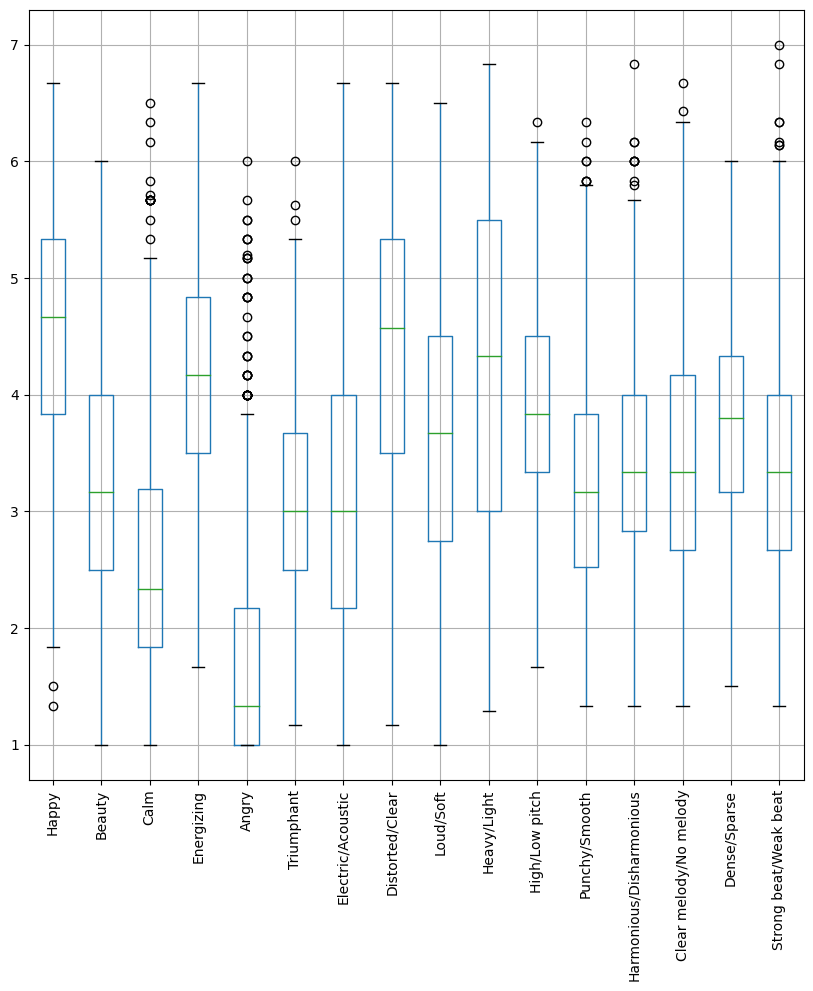

In [5]:
# emotions_and_mid_level
fig, ax = plt.subplots(figsize=(10, 10))
emotions_and_mid_level.boxplot(ax=ax, rot=90)
plt.show()

In [6]:
not_found = 0
for stimulus_id in groundtruth_df.index:
    if not os.path.exists(f"{modality}/embeddings_{which}/{stimulus_id}{fn_suffix[modality][which]}.npy"):
        print(f"Embedding for {stimulus_id} not found")
        not_found += 1

assert not_found == 0

## Load embeddings

In [7]:
embedding_dim = embedding_dimensions[modality][which]

X = np.empty((groundtruth_df.shape[0], embedding_dim))
y_reg = np.empty((emotions_and_mid_level.shape[0], emotions_and_mid_level.shape[1]))

for i,stimulus_id in enumerate(groundtruth_df.index):
    embedding = np.load(f"{modality}/embeddings_{which}{'' if voice else '_novoice'}/" +
                        f"{stimulus_id}{fn_suffix[modality][which]}.npy")
    X[i] = embedding.mean(axis=0)
    y_reg[i] = emotions_and_mid_level.loc[stimulus_id].values

X.shape, y_reg.shape

((606, 512), (606, 16))

In [8]:
classes = ["Girls/women", "Boys/men"] if n_classes==2 else ["Girls/women", "Mixed", "Boys/men"]

y_cls = groundtruth_df.target.values

# convert to integers, and when the classes are not in 'classes' set them to -1
y_cls = groundtruth_df.target.values
y_cls = [classes.index(x) if x in classes else -1 for x in y_cls]
y_cls = np.array(y_cls)

pd.Series(y_cls).value_counts()

-1    294
 0    163
 1    149
dtype: int64

### partially annotated data will be handeled by the model, see utils.py

In [9]:
params = {
    "input_dim": X.shape[1], 
    "n_regressions": y_reg.shape[1], 
    "output_dim": n_classes,
    }

kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
f1s = []
r2s = []
pearsons = []
ps = []
for train_index, test_index in kf.split(X):

    test_index, val_index = train_test_split(test_index, test_size=0.5, random_state=42)
    
    X_train, X_test, X_val = X[train_index], X[test_index], X[val_index]
    y_reg_train, y_reg_test, y_reg_val = y_reg[train_index], y_reg[test_index], y_reg[val_index]
    y_cls_train, y_cls_test, y_cls_val = y_cls[train_index], y_cls[test_index], y_cls[val_index]

    train_dataset = EmbeddingsDataset2(X_train, y_reg_train, y_cls_train)
    val_dataset = EmbeddingsDataset2(X_val, y_reg_val, y_cls_val)
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1)
 
    model = MultipleRegressionWithSoftmax(**params)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_loss')
    trainer = pl.Trainer(max_epochs=100,
                         callbacks=[checkpoint_callback, EarlyStopping(monitor='val_loss', patience=30)],
                         enable_progress_bar = False,
                         accelerator='gpu',
                         devices=1)
    trainer.fit(model, train_loader, val_loader)

    # load best model
    model = model.load_from_checkpoint(checkpoint_callback.best_model_path, **params)
    
    # evaluate
    model.eval()
    with torch.no_grad():
        y_reg_pred, out_cls = model(torch.from_numpy(X_test).float())
    
    skip_unlabelled = y_cls_test != -1
    y_cls_pred = torch.argmax(out_cls, dim=1).numpy()[skip_unlabelled]
    y_cls_test = y_cls_test[skip_unlabelled]

    accuracies.append(accuracy_score(y_cls_test, y_cls_pred))
    f1s.append(f1_score(y_cls_test, y_cls_pred, average='weighted'))

    r2_values = r2_score(y_reg_test, y_reg_pred, multioutput='raw_values')
    r2s.append(r2_values)

    r = [pearsonr(y_reg_test[:,i], y_reg_pred[:,i])[0] for i in range(y_reg_test.shape[1])]
    p = [pearsonr(y_reg_test[:,i], y_reg_pred[:,i])[1] for i in range(y_reg_test.shape[1])]
    pearsons.append(r)
    ps.append(p)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name    | Type   | Params
-----------------------------------
0 | linear  | Linear | 65.7 K
1 | linear2 | Linear | 2.1 K 
2 | linear3 | Linear | 258   
-----------------------------------
68.0 K    Trainable params
0         Non-trainable params
68.0 K    Total params
0.272     Total estimated model params size (MB)
/homes/lm004/.conda/envs/embeddings_pipeline_dev/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/homes/lm004/.conda/envs/embeddings_pipeline_dev/lib/pyth

In [10]:
print(f"Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
print(f"F1: {np.mean(f1s):.2f} ± {np.std(f1s):.2f}")

Accuracy: 0.89 ± 0.06
F1: 0.89 ± 0.06


In [11]:
# transpose to get r2s per feature
r2s = np.array(r2s).T

for i, r2 in enumerate(r2s):
    print(f"R2 for {emotions_and_mid_level.columns[i]}: {np.mean(r2):.2f} ± {np.std(r2):.2f}")

R2 for Happy: 0.26 ± 0.05
R2 for Beauty: 0.25 ± 0.11
R2 for Calm: 0.36 ± 0.08
R2 for Energizing: 0.27 ± 0.13
R2 for Angry: 0.45 ± 0.05
R2 for Triumphant: 0.22 ± 0.07
R2 for Electric/Acoustic: 0.29 ± 0.06
R2 for Distorted/Clear: 0.48 ± 0.05
R2 for Loud/Soft: 0.58 ± 0.07
R2 for Heavy/Light: 0.69 ± 0.04
R2 for High/Low pitch: 0.45 ± 0.07
R2 for Punchy/Smooth: 0.53 ± 0.09
R2 for Harmonious/Disharmonious: 0.40 ± 0.08
R2 for Clear melody/No melody: 0.37 ± 0.02
R2 for Dense/Sparse: 0.48 ± 0.02
R2 for Strong beat/Weak beat: 0.48 ± 0.09


In [12]:
# compute standard deviation by row, and then average over all rows
print(f"Average R2 for all responses: {np.mean(r2s):.2f} ± {np.mean(np.std(r2s, axis=1)):.2f}")

Average R2 for all responses: 0.41 ± 0.07


In [13]:
# transpose to get pearsons per feature
pearsons = np.array(pearsons).T
ps = np.array(ps).T

p2star = lambda p: ''.join(['*' for alpha in [0.001,0.01,0.05] if p<=alpha/len(ps[0])]) # Bonferroni correction

for i, r in enumerate(pearsons):
    print(f"Pearson's r for {emotions_and_mid_level.columns[i]}: {np.mean(r):.2f} ± {np.std(r):.2f} , significances {[p2star(p) for p in ps[i]]}")

Pearson's r for Happy: 0.53 ± 0.03 , significances ['***', '***', '***', '***', '***']
Pearson's r for Beauty: 0.52 ± 0.09 , significances ['***', '***', '***', '*', '***']
Pearson's r for Calm: 0.62 ± 0.06 , significances ['***', '***', '***', '***', '***']
Pearson's r for Energizing: 0.59 ± 0.10 , significances ['***', '***', '***', '**', '***']
Pearson's r for Angry: 0.69 ± 0.05 , significances ['***', '***', '***', '***', '***']
Pearson's r for Triumphant: 0.50 ± 0.07 , significances ['**', '***', '***', '***', '***']
Pearson's r for Electric/Acoustic: 0.57 ± 0.04 , significances ['***', '***', '***', '***', '***']
Pearson's r for Distorted/Clear: 0.71 ± 0.04 , significances ['***', '***', '***', '***', '***']
Pearson's r for Loud/Soft: 0.79 ± 0.03 , significances ['***', '***', '***', '***', '***']
Pearson's r for Heavy/Light: 0.84 ± 0.02 , significances ['***', '***', '***', '***', '***']
Pearson's r for High/Low pitch: 0.69 ± 0.05 , significances ['***', '***', '***', '***', '**

In [14]:
print(f"Average Pearson's r for all responses: {np.mean(pearsons):.2f} ± {np.mean(np.std(pearsons, axis=1)):.2f}")

Average Pearson's r for all responses: 0.66 ± 0.05


### Let's see how the last trained model performs on the unlabeled data of the test set

In [15]:
test_commercials = groundtruth_df.index[test_index]
no_actors_commercials = groundtruth_df[groundtruth_df.target == "There are no actors/presenters or you can never see their faces"].index
unseen_no_actors_commercials = no_actors_commercials.intersection(test_commercials)

In [16]:
for stimulus_id in unseen_no_actors_commercials:
        # retrieve embedding
        embedding = np.load(f"{modality}/embeddings_{which}{'' if voice else '_novoice'}/" +
                            f"{stimulus_id}{fn_suffix[modality][which]}.npy")
        
        # predict
        with torch.no_grad():
            y_reg_pred, out_cls = model(torch.from_numpy(embedding.mean(axis=0)).float())

        y_cls_pred = torch.argmax(out_cls).numpy()

        # print results
        print(f"https://www.youtube.com/watch?v={stimulus_id} - predicted {classes[y_cls_pred]}")

        print("Regression:")
        for i, feature in enumerate(emotions_and_mid_level.columns):
            print(f"\t{feature}: predicted {y_reg_pred[i]:.2f}, actual {emotions_and_mid_level.loc[stimulus_id, feature]:.2f}")
        
        # # write to text file all the results
        # with open(f"results_{modality}_{which}.txt", "a") as f:
        #     f.write(f"https://www.youtube.com/watch?v={stimulus_id} - predicted {classes[y_cls_pred]}\n")
        #     f.write("Regression:\n")
        #     for i, feature in enumerate(emotions_and_mid_level.columns):
        #         f.write(f"\t{feature}: predicted {y_reg_pred[i]:.2f}, actual {emotions_and_mid_level.loc[stimulus_id, feature]:.2f}\n")


https://www.youtube.com/watch?v=z6cj2wHF1rA - predicted Girls/women
Regression:
	Happy: predicted 4.39, actual 5.33
	Beauty: predicted 3.24, actual 3.50
	Calm: predicted 3.04, actual 3.50
	Energizing: predicted 3.07, actual 3.00
	Angry: predicted 1.23, actual 1.00
	Triumphant: predicted 2.67, actual 3.17
	Electric/Acoustic: predicted 3.62, actual 1.33
	Distorted/Clear: predicted 5.10, actual 4.50
	Loud/Soft: predicted 3.32, actual 3.83
	Heavy/Light: predicted 4.90, actual 4.67
	High/Low pitch: predicted 2.87, actual 3.17
	Punchy/Smooth: predicted 3.31, actual 2.17
	Harmonious/Disharmonious: predicted 2.58, actual 2.50
	Clear melody/No melody: predicted 2.65, actual 2.50
	Dense/Sparse: predicted 3.67, actual 5.00
	Strong beat/Weak beat: predicted 3.11, actual 3.67
https://www.youtube.com/watch?v=gmKuMXGtLiU - predicted Boys/men
Regression:
	Happy: predicted 3.57, actual 4.50
	Beauty: predicted 2.13, actual 2.00
	Calm: predicted 1.69, actual 1.83
	Energizing: predicted 5.14, actual 6.33
